In [1]:
from ipynb.fs.full.deck_visualization import visualize_deck as vd
from ipynb.fs.full.jigsaw_visualization import visualize_deck as vjd
import random, copy

**This project was created by Bianka Nagy, Panna Ottó and Hunor Csapó for the course _Zero Knowledge Proofs and applications_.**

January 12, 2025

# Provide a non-interactive short ZK argument that shows that you have solved a Sudoku-like puzzle: Jigsaw Sudoku

For this assignment, we have updated the following paper's protocol: https://www.tains.tohoku.ac.jp/netlab/mizuki/conf/zerosuno_fct2023_web.pdf, to make it applicable to Jigsaw Sudoku.

> _The rules of jigsaw sudoku are as follows:_
> _Place the numbers from 1-9 once in each row, column and bold-lined jigsaw region._

> _The rules of jigsaw sudoku are very simple, as with standard sudoku itself. However, jigsaw sudoku are generally trickier to solve than standard sudoku. This is partly because it is harder for the human eye to work with the wiggly, irregular-shaped regions that replace the orderly 3x3 boxes in standard sudoku puzzles. We often miss deductions that we would spot easily if the grid had its more familiar shape as per regular sudoku grids._

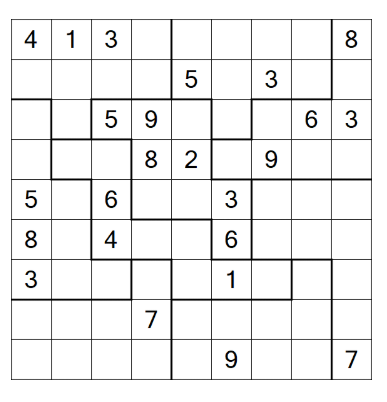

Our idea is to use "new type" of cards. This cards, whould have 3 different sides:
- backside of a card (no information)
- number from 1-9 and a color from: Yellow, Red, Blue
- number from 1-9 (without color information)

In physical implementation we could use a device which would hide 2 side of the card, and with rotation we could diclose other sides of the card.
E.g.: card is 9; ?; 9Y; the device is on it's empty side, if we rotate to left, we would get the number side, if we rotate to the right side we would get the number and color side.





For Jigsaw Sudoku we have to redefine what we call a block, how can we identify them, and calculate with them.

For the computation, we mark ever block with it's own unique identifier letter ( a-i ). Identifying the order of the blocks:
A block's top row's, leftest number will be the identifying cell.

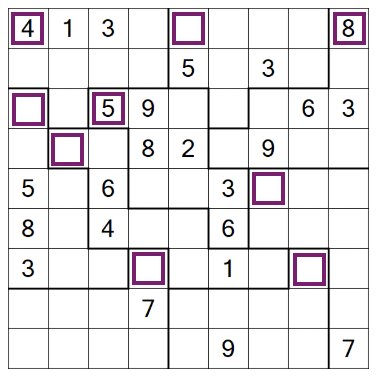

The 9 block give us 9 different cells: from left to right and from top to bottom, we give an identifying letter to each block.

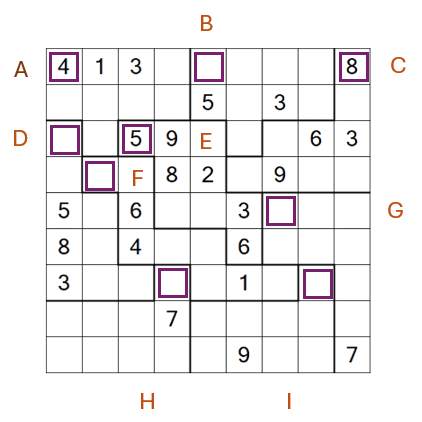

The users of the protocol knows about the block identifying process, and we even want the Prover (P) to give the solution with the block identification.

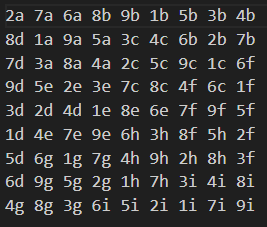


## 1. Get a Jigsaw Sudoku

Here is the Jigsaw Sudoku that has to be solved. We read it in into the variable $table$. The structure of the Sudoku file is simple, the empty cells are '0' zeros.

The cells are divided by space (' '), the first number is the value of the cell, the second value is the identifier of the block.

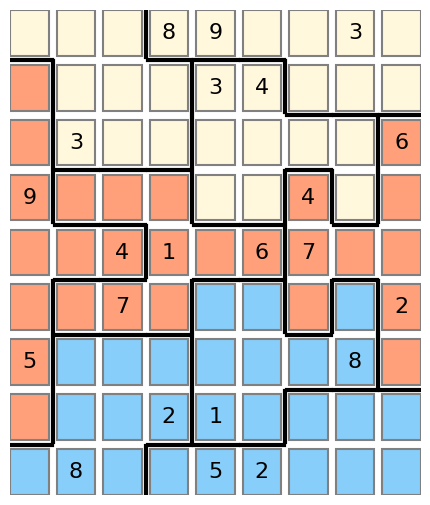

In [2]:
# a-b-c Yellow
# d-e-f Red
# g-h-i Blue

table = open("jigsaw_sudoku/01.txt", "r")
table = table.read()
deck = []
blocks = [] # store the placement of the blocks

for idx, row in enumerate(table.split('\n')):
    temp = []
    temp1 = [] # store the placement of the blocks
    for idy, x in enumerate(row.split(' ')):
        temp1.append(x[1])
        num = ''
        if x[0] == '0':
            num = ' '
        else:
            num = x[0]

        color = "white"
        if x[1] in ('a', 'b', 'c'):
            color = "cornsilk"
        elif x[1] in ('d', 'e',  'f'):
            color = "lightsalmon"
        elif x[1] in ('g', 'h', 'i'):
            color = "lightskyblue"

        temp.append({"number": num, "color": color})
    deck.append(temp)
    blocks.append(temp1)

vjd(deck, blocks)

The table that is drawn out above is the same as in the *jigsaw_sudoku/01.txt*:
- 0a 0a 0a 8b 9b 0b 0b 3b 0b
- 0d 0a 0a 0a 3c 4c 0b 0b 0b
- 0d 3a 0a 0a 0c 0c 0c 0c 6f
- 9d 0e 0e 0e 0c 0c 4f 0c 0f
- 0d 0d 4d 1e 0e 6e 7f 0f 0f
- 0d 0e 7e 0e 0h 0h 0f 0h 2f
- 5d 0g 0g 0g 0h 0h 0h 8h 0f
- 0d 0g 0g 2g 1h 0h 0i 0i 0i
- 0g 8g 0g 0i 5i 2i 0i 0i 0i

## 1.1: A Prover (P) commits a solution

The Prover (P) has to provide a solution for the given task. This is the *jigsaw_sudoku/01_sol.txt*.

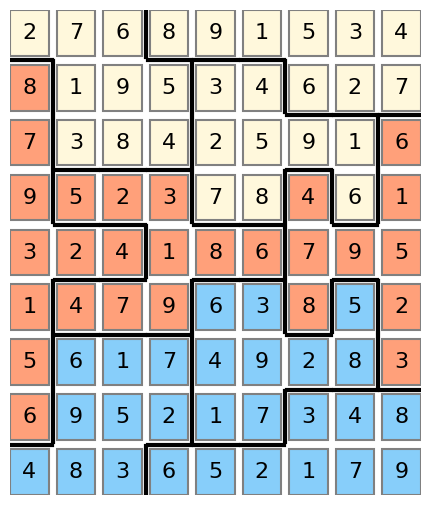

In [3]:
# a-b-c Yellow
# d-e-f Red
# g-h-i Blue

table = open("jigsaw_sudoku/01_sol.txt", "r")
table = table.read()
deck = []
blocks = []
for idx, row in enumerate(table.split('\n')):
    temp = []
    temp1 = [] # for blocks
    for idy, x in enumerate(row.split(' ')):
        num = ''
        if x[0] == '0':
            num = ' '
        else:
            num = x[0]

        color = "white"
        if x[1] in ('a', 'b', 'c'):
            color = "cornsilk"
        elif x[1] in ('d', 'e',  'f'):
            color = "lightsalmon"
        elif x[1] in ('g', 'h', 'i'):
            color = "lightskyblue"

        temp.append({"number": num, "color": color})
        temp1.append(x[1])

    deck.append(temp)
    blocks.append(temp1)

vjd(deck, blocks)

## 2. Preliminaries

### 2.1 Pile-Scramble Shuffle

Pile-Scramble Shuffle is a basic protocol which shuffles a given deck (numbered $1,..,n$) as follows:
1. The protocol divides the deck into $k$ piles ($1\le k \le n$)
2. We re-order the $k$ piles with random permutation
3. Return the merged deck

An example can be found in _main.py_ Section 2.1.

In [4]:
def pile_shuffle(deck, k):
    split_by_k = []
    k_temp = 0
    temp = []
    for card in deck:
        temp.append(card)
        k_temp += 1
        if k_temp == k:
            split_by_k.append(temp)
            temp = []
            k_temp = 0
    
    return [card for pile in random.sample(split_by_k, len(split_by_k)) for card in pile]

### 2.2 Uniqueness Verification Protocol

With this protocol, we can check if a given deck (with cards from 1 to $n$) contains only unique sets. We will use this funtion in the actual proof.

The question is that how can we make sure, if a given deck contains all the required cards that we need, without knowing the original order?

This is why we use a **helper deck**. A helper deck is a (here numbered) unique deck ($1 \le helper \le 27$), basically an ID to the original cards.

1. We leave the $deck$ in the given order (and face down), and place the $helper$ cards below. We turn the $helper$ face down, and apply to ($deck$ - $helper$) a Pile-Scramble-Shuffle.
2. We turn over all the cards of the top sequence to verify that it consists of all the elements that we need.
3. We turn $cards$ face down again, apply another Pile-Scramble-Shuffle, and now, we turn over all the cards of the bottom sequence.
4. After sorting the $helper$ deck as it was, we actually restored the original $deck$ order (without knowing what that was).

In [5]:
# Helper functions


# Given 2 arrays, merge them into a single array by alternating elements from each array
# Example:
# deck1: [1,2,3]
# deck2: [4,5,6]
# result: [1,4,2,5,3,6]
def merge_decks(deck1, deck2):
    temp = []
    for x in range(0, len(deck1)):
        temp.append(deck1[x])
        temp.append(deck2[x])
    return temp


# Given a deck, split it into 2 decks by alternating elements from the original deck
# Example:
# deck: [1,4,2,5,3,6]
# deck1: [1,2,3]
# deck2: [4,5,6]
def split_decks(deck):
    deck1 = []
    deck2 = []
    for idx, card in enumerate(deck):
        if idx % 2 == 0:
            deck1.append(card)
        else:
            deck2.append(card)
    return deck1, deck2


# Create a "?" row with a given number of columns
# Example:
# empty_row(2)
# [{"number": "?", "color": "white"}, {"number": "?", "color": "white"}]
def empty_row(num):
    return [{"number": "?", "color": "white"} for _ in range(0, num)]

In [6]:
# Uniqueness Ver. Prot. with Visualizing the Deck (vd)
def unique_with_vd(deck, checker):
    k = len(deck)
    # Create the helper deck with numbers 1-9
    help_deck = []
    for x in range(1,len(deck)+1):
        help_deck.append({"number": x, "color": "white"})

    # We need to merge the normal and the helping deck
    # so we can shuffle them together by pairs (k = 2)
    print('Deck is shuffled with pile shuffle, we can check if 1-9 numbers are present only once')
    merged = pile_shuffle(merge_decks(deck, help_deck), 2)
    deck1, deck2 = split_decks(merged) # we just have to split it, so we can draw it out
    vd([deck1, empty_row(k)])

    # Here we check if 1-9 cards are present only once of each color
    for x in deck1:
        found = False
        for card in checker:
            if int(card["number"]) == int(x["number"]) and card["color"] == x["color"]:
                checker.remove(card)
                found = True
                break
        if not found:
            print('There is a duplicate in the deck or an unexpected card.')
            print('Problematic card:', x)
            print('Remaining checker:', checker)
            return False

    # We have to shuffle again, so won't know the orders
    print('Deck is shuffled again, now the helping deck is revealed, so we can sort it to the original state')
    deck1, deck2 = split_decks(pile_shuffle(merged, 2))
    vd([empty_row(k), deck2])

    # We have to sort the revealed helping deck, so we can restore the original sequence
    print("Sort the helping deck, so the row is restored to the original sequence without knowing the exact order")
    paired_decks = list(zip(deck1, deck2))
    sorted_paired_decks = sorted(paired_decks, key=lambda x: x[1]['number'])
    sorted_deck1, sorted_deck2 = zip(*sorted_paired_decks)
    sorted_deck2 = list(sorted_deck2)

    #vd([sorted_deck1, sorted_deck2])
    vd([empty_row(k), sorted_deck2])

    return True

In [7]:
# This is the same as the unique_with_vd function, but without the visualization
def unique(deck, checker):
    # Creating the helper deck
    help_deck = []
    for x in range(1, len(deck) + 1):
        help_deck.append({"number": x, "color": "white"})

    # Merging the decks and shuffling them
    merged = pile_shuffle(merge_decks(deck, help_deck), 2)
    deck1, _ = split_decks(merged)

    # Here we check if 1-9 cards are present only once of each color
    for x in deck1:
        found = False
        for card in checker:
            if int(card["number"]) == int(x["number"]) and card["color"] == x["color"]:
                checker.remove(card)
                found = True
                break
        if not found:
            print("There is a duplicate in the deck or an unexpected card.")
            print("Problematic card:", x)
            print("Remaining checker:", checker)
            return False
    return True

### 2.3 Helper vector

In [8]:
a = [
    [{"number": i, "color": "cornsilk"} for i in range(1, 10)],
    [{"number": i, "color": "lightsalmon"} for i in range(1, 10)],
    [{"number": i, "color": "lightskyblue"} for i in range(1, 10)],
    [{"number": i, "color": "white"} for i in range(1, 10)],
]

# 3. Sub-protocols

## 3.1 Row Verification Sub-protocol

> The row verification sub-protocol can verify that each of the rows consists of numbers 1 through 9.

**For this Sub-protocol we used the card's "only number" side.**

Since in a Jigsaw Sudoku there is not an equal number of colors in a row (e.g.: 2 yellow, 6 red, 1 blue)

If we would show the result of this 9 card's shuffle, we would disclose some information (red card's number) $\Rightarrow$ this couldn't be a ZKP.

And for this reason we also lessened the number of rows we check in a cycle (Sudoku: 3, Jigsaw: 1).
The number of colors and the number of cycles are in inverse proportion:
- Sudoku: 3 color, 3 cycle
- Jigsaw: 1 color, 9 cycle

In [9]:
def row_ver(deck):
    for i in range(0, 9):
        row = [{"number": x["number"], "color": "white"} for x in deck[i]]
        checker = copy.deepcopy(a)
        checker = checker[3]
        if not unique(row, checker):
            print("Duplicate number in row")
            print(row)
            return False
    return True


row_ver(deck)

True

Deck is shuffled with pile shuffle, we can check if 1-9 numbers are present only once


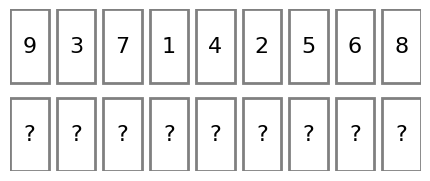

Deck is shuffled again, now the helping deck is revealed, so we can sort it to the original state


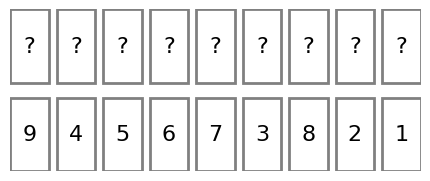

Sort the helping deck, so the row is restored to the original sequence without knowing the exact order


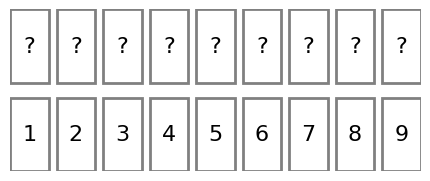

True

In [10]:
row = [{"number": x["number"], "color": "white"} for x in deck[0]]
checker = copy.deepcopy(a)
checker = checker[3]
unique_with_vd(row, checker)

### 3.2 Column Verification Sub-protocol

> The column verification sub-protocol can verify that each of the columns consists of numbers 1 through 9.

**For this Sub-protocol we used the card's "only number" side.**

Since in a Jigsaw Sudoku there is not an equal number of colors in a column (e.g.: 2 yellow, 6 red, 1 blue)

If we would show the result of this 9 card's shuffle, we would disclose some information (red card's number) $\Rightarrow$ this couldn't be a ZKP.

And for this reason we also lessened the number of columns we check in a cycle (Sudoku: 3, Jigsaw: 1).
The number of colors and the number of cycles are in inverse proportion:
- Sudoku: 3 color, 3 cycle
- Jigsaw: 1 color, 9 cycle

In [11]:
def col_ver(deck):
    for i in range(0, 9):
        col = [{"number": row[i]["number"], "color": "white"} for row in deck]
        checker = copy.deepcopy(a)
        checker = checker[3]
        if not unique(col, checker):
            print("Duplicate number in column")
            print(col)
            return False
    return True


col_ver(deck)

True

Deck is shuffled with pile shuffle, we can check if 1-9 numbers are present only once


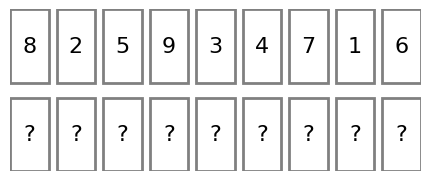

Deck is shuffled again, now the helping deck is revealed, so we can sort it to the original state


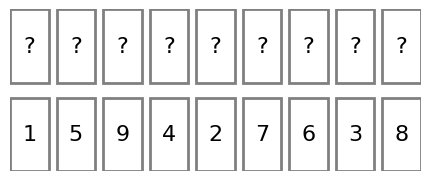

Sort the helping deck, so the row is restored to the original sequence without knowing the exact order


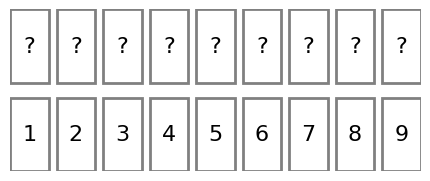

True

In [12]:
col = [{"number": row[0]["number"], "color": "white"} for row in deck]
checker = copy.deepcopy(a)
checker = checker[3]
unique_with_vd(col, checker)

### 3.3 Color Verification Sub-protocol

Given a commitment to a solution, we first want to check that the face-down cards satisfy the color scheme properly. To do so, we need 3 rows from the Sudoku.

In this protocol, we want to verify that all cards have the same color, and all the numbers from 1-9 appears 3 times (or 1 time per set).

In [13]:

def color_ver(deck):
    blocks_by_color = ["abc", "def", "ghi"]
    for i in range(0, 3):
        block = []
        for x in range(len(blocks)):
            for y in range(len(blocks[x])):
                if blocks[x][y] in blocks_by_color[i]:
                    block.append(deck[x][y])
        checker = copy.deepcopy(a)
        checker = checker[i] + checker[i] + checker[i]
        if not unique(block, checker):
            print("Duplicate number in blocks")
            print(block)
            return False
    return True

color_ver(deck)

True

Deck is shuffled with pile shuffle, we can check if 1-9 numbers are present only once


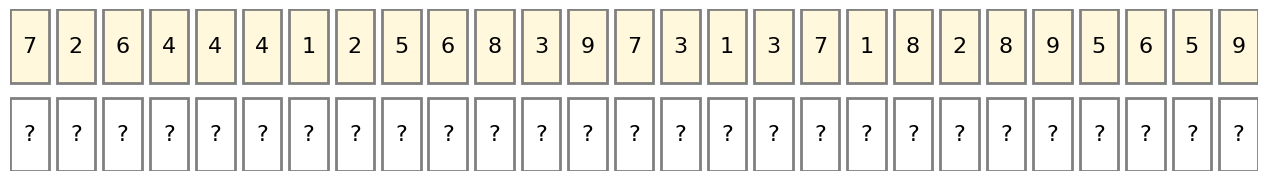

Deck is shuffled again, now the helping deck is revealed, so we can sort it to the original state


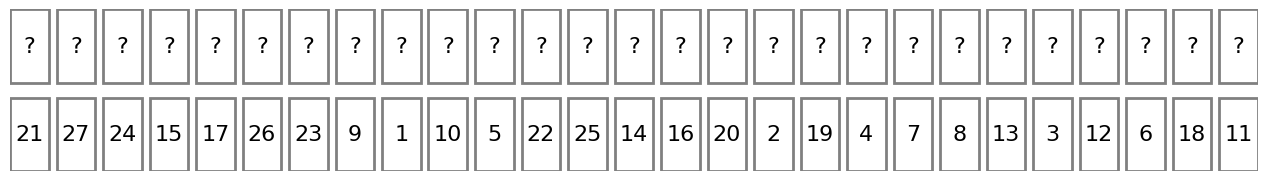

Sort the helping deck, so the row is restored to the original sequence without knowing the exact order


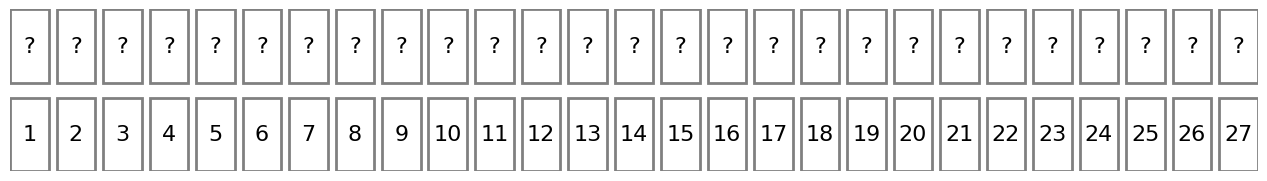

True

In [14]:
blocks_by_color = ["abc", "def", "ghi"]
block = []
for x in range(len(blocks)):
    for y in range(len(blocks[x])):
        if blocks[x][y] in blocks_by_color[0]:
            block.append(deck[x][y])
checker = copy.deepcopy(a)
checker = checker[0] + checker[0] + checker[0]
unique_with_vd(block, checker)

### 3.4 3-block Verification Sub-protocol

Our proposed verification for Jigsaw Sudoku does not need a Color Change Sub-protocol.

In our previous verification, the Color Change Sub-protocol guaranteed the Block verification for the Sudoku, so for Jigsaw Sudoku we had to re-implement the Block Verification.

In [15]:
def block_ver(deck):
    blocks_by_color = ["adg", "beh", "cfi"]
    for i in range(0, 3):
        block = []
        for x in range(len(blocks)):
            for y in range(len(blocks[x])):
                if blocks[x][y] in blocks_by_color[i]:
                    block.append(deck[x][y])
        checker = copy.deepcopy(a)
        checker = checker[0] + checker[1] + checker[2]
        if not unique(block, checker):
            print("Duplicate number in blocks")
            print(block)
            return False
    return True


block_ver(deck)

True

Deck is shuffled with pile shuffle, we can check if 1-9 numbers are present only once


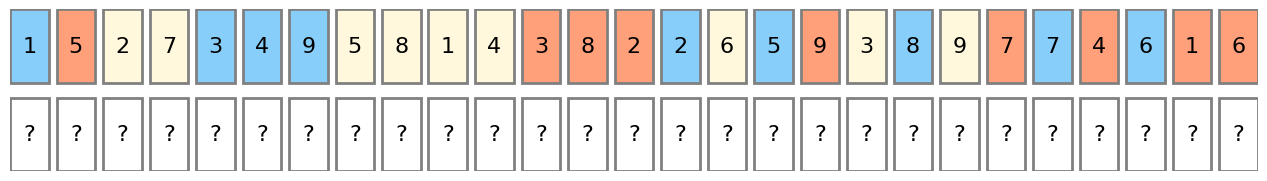

Deck is shuffled again, now the helping deck is revealed, so we can sort it to the original state


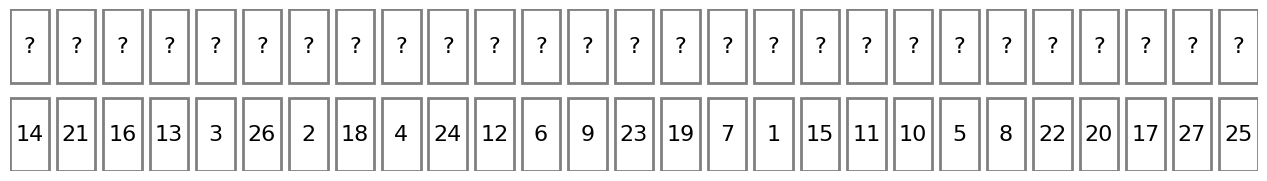

Sort the helping deck, so the row is restored to the original sequence without knowing the exact order


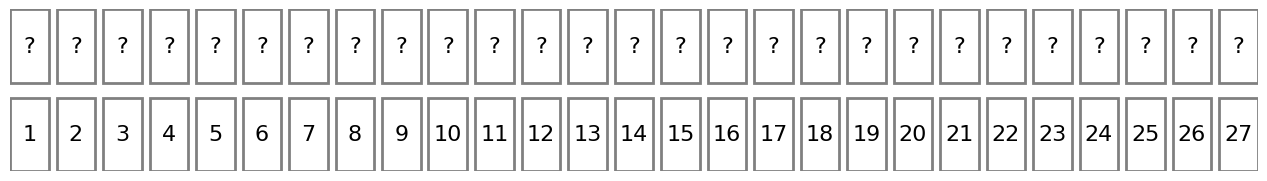

True

In [16]:
blocks_by_color = ["adg", "beh", "cfi"]
block = []
for x in range(len(blocks)):
    for y in range(len(blocks[x])):
        if blocks[x][y] in blocks_by_color[0]:
            block.append(deck[x][y])
checker = copy.deepcopy(a)
checker = checker[0] + checker[1] + checker[2]
unique_with_vd(block, checker)

# The protocol for 9x9 Jigsaw Sudoku

> This is the proposed protocol for convincing a verifier that the numbers 1 to 9 appear exactly once in each row, each column, and each block.

Althouh as a verifier, we cannot actually see the results, here in the code we printed it out, so we can see if the zero-knowledge proof works perfectly.

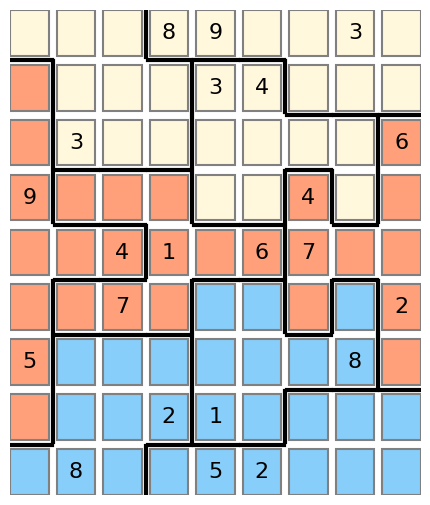

In [17]:
# A prover P who knows a solution places a commitment to the solution => deck
# and this is the input to the protocol. 

table = open("jigsaw_sudoku/01.txt", "r")
table = table.read()
deck = []
blocks = [] # store the placement of the blocks

for idx, row in enumerate(table.split('\n')):
    temp = []
    temp1 = [] # store the placement of the blocks
    for idy, x in enumerate(row.split(' ')):
        temp1.append(x[1])
        num = ''
        if x[0] == '0':
            num = ' '
        else:
            num = x[0]

        color = "white"
        if x[1] in ('a', 'b', 'c'):
            color = "cornsilk"
        elif x[1] in ('d', 'e',  'f'):
            color = "lightsalmon"
        elif x[1] in ('g', 'h', 'i'):
            color = "lightskyblue"

        temp.append({"number": num, "color": color})
    deck.append(temp)
    blocks.append(temp1)

vjd(deck, blocks)

This should be the real solution:

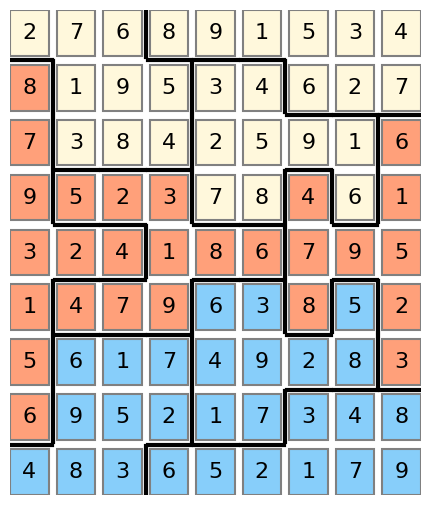

In [18]:
table = open("jigsaw_sudoku/01_sol.txt", "r")
table = table.read()
deck = []
blocks = []
for idx, row in enumerate(table.split('\n')):
    temp = []
    temp1 = [] # for blocks
    for idy, x in enumerate(row.split(' ')):
        num = ''
        if x[0] == '0':
            num = ' '
        else:
            num = x[0]

        color = "white"
        if x[1] in ('a', 'b', 'c'):
            color = "cornsilk"
        elif x[1] in ('d', 'e',  'f'):
            color = "lightsalmon"
        elif x[1] in ('g', 'h', 'i'):
            color = "lightskyblue"

        temp.append({"number": num, "color": color})
        temp1.append(x[1])

    deck.append(temp)
    blocks.append(temp1)

vjd(deck, blocks)

If all the 4 sub-protocols returns with True, we can convince a Verifier that the numbers 1 to 9 appear exactly once in each row, each column, and each block.

In [19]:
# Apply the Row Verification Sub-protocol
print(row_ver(deck))

#Apply the Column Verification Sub-protocol
print(col_ver(deck))

# Apply the Color Verification Sub-protocol
print(color_ver(deck))

# Apply the 3-block Verification Sub-protocol
print(block_ver(deck))

True
True
True
True


This is the deck after all the protocols:

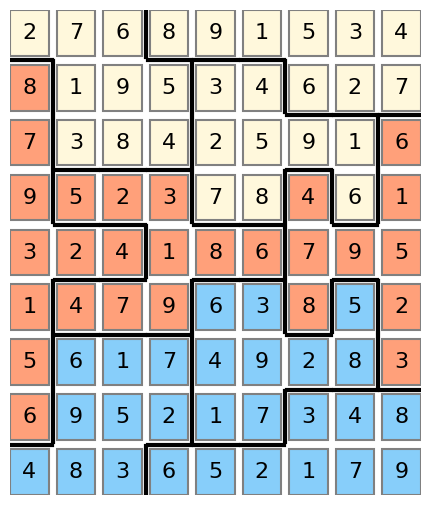

In [20]:
vjd(deck, blocks)